In [69]:
import numpy as np
import matplotlib.pyplot as plt

G = 0.01

def derivatives(t, y):
    """
    y는 다음 순서로 구성:
    y = [y1_e, y2_e, y1_g, y2_g, y_1_e, y_2_e, y_1_g, y_2_g]
    """
    y1_e, y2_e, y1_g, y2_g, y_1_e, y_2_e, y_1_g, y_2_g = y
    
    # G_t 값 결정 (t=0 일 때만 G, 이후로는 0)
    if t < 1e-4:
        Gval = G
    else:
        Gval = 0.0  
        
    # 미분방정식에 따라 dy/dt 계
    dy1_e = Gval * y1_g - kr1 * y1_e - k12 * y1_e * y2_g - k11 * y1_e * y_1_g - k12 * y1_e * y_2_g + k11 * y_1_e * y1_g
    dy2_e = Gval * y2_g - kr1 * y2_e + k12 * y1_e * y2_g - k22 * y2_e * y_2_g + k12 * y_1_e * y2_g + k22 * y_2_e * y2_g
    dy1_g = -dy1_e
    dy2_g = -dy2_e

    dy_1_e = Gval * y_1_g - (kr1 + kn1) * y_1_e + k11 * y1_e * y_1_g - k12 * y_1_e * y2_g - k11 * y_1_e * y1_g - k12 * y_1_e * y_2_g ##
    dy_2_e = Gval * y_2_g - (kr1 + kn1) * y_2_e + k12 * y1_e * y_2_g + k22 * y2_e * y_2_g + k12* y_1_e * y_2_g - k22 * y_2_e * y2_g
    dy_1_g = -dy_1_e
    dy_2_g = -dy_2_e
    
    return [dy1_e, dy2_e, dy1_g, dy2_g, dy_1_e, dy_2_e, dy_1_g, dy_2_g]

def derivatives_vectorized(t, y, params_vec, G_val):
    # Extract parameters
    q, m, kr1, k12, k11, k22, kn1, mix = params_vec.T
    
    # Extract state variables for all parameter sets
    # y = [y1_e, y2_e, y1_g, y2_g, y_1_e, y_2_e, y_1_g, y_2_g]
    y1_e, y2_e, y1_g, y2_g, y_1_e, y_2_e, y_1_g, y_2_g = y.T
    
    # G_t value determination (G only when t < 1e-4, otherwise 0)
    if t < 1e-4:
        Gval = G_val
    else:
        Gval = 0.0
    
    # Calculate derivatives for all parameter sets simultaneously
    dy1_e = (Gval * y1_g - kr1 * y1_e - k12 * y1_e * y2_g - k11 * y1_e * y_1_g - k12 * y1_e * y_2_g + k11 * y_1_e * y1_g)
    dy2_e = (Gval * y2_g - kr1 * y2_e + k12 * y1_e * y2_g - k22 * y2_e * y_2_g + k12 * y_1_e * y2_g + k22 * y_2_e * y2_g)
    
    dy1_g = -dy1_e
    dy2_g = -dy2_e
    
    dy_1_e = (Gval * y_1_g - (kr1 + kn1) * y_1_e + k11 * y1_e * y_1_g - k12 * y_1_e * y2_g - k11 * y_1_e * y1_g - k12 * y_1_e * y_2_g)
    dy_2_e = (Gval * y_2_g - (kr1 + kn1) * y_2_e + k12 * y1_e * y_2_g + k22 * y2_e * y_2_g + k12 * y_1_e * y_2_g - k22 * y_2_e * y2_g)
    
    dy_1_g = -dy_1_e
    dy_2_g = -dy_2_e
    
    # Stack derivatives
    dydt = np.column_stack([dy1_e, dy2_e, dy1_g, dy2_g, dy_1_e, dy_2_e, dy_1_g, dy_2_g])
    return dydt

In [70]:
def runge_kutta_vectorized(params, t_span, dt=0.01):
    n_params = params.shape[0]
    
    # Extract parameters for all sets at once
    q = params[:, 0]    # shape: (n,)
    m = params[:, 1]    # shape: (n,)
    kr1 = params[:, 2]  # shape: (n,)
    k12 = params[:, 3]  # shape: (n,)
    k11 = params[:, 4]  # shape: (n,)
    k22 = params[:, 5]  # shape: (n,)
    kn1 = params[:, 6]  # shape: (n,)
    mix = params[:, 7]  # shape: (n,)
    
    # Time setup
    t_start, t_end = t_span
    t = np.arange(t_start, t_end + dt, dt)
    n_steps = len(t)
    
    # Initial conditions for all parameter sets
    # y_init shape: (n, 8) - each row is initial state for one parameter set
    y_init = np.zeros((n_params, 8))
    y_init[:, 2] = m * (1.0 - q)           # state 2
    y_init[:, 3] = (1.0 - m) * (1.0 - q)   # state 3
    y_init[:, 6] = m * q                   # state 6
    y_init[:, 7] = (1.0 - m) * q           # state 7
    
    # Solution array: (n_params, n_steps, 8)
    y_all = np.zeros((n_params, n_steps, 8))
    y_all[:, 0, :] = y_init
    
    # Current state for all parameter sets
    y_current = y_init.copy()  # shape: (n_params, 8)
    
    for i in range(1, n_steps):
        t_current = t[i-1]
        
        k1 = dt * derivatives_vectorized(t_current, y_current, params, G)
        k2 = dt * derivatives_vectorized(t_current + dt/2, y_current + k1/2, params, G)
        k3 = dt * derivatives_vectorized(t_current + dt/2, y_current + k2/2, params, G)
        k4 = dt * derivatives_vectorized(t_current + dt, y_current + k3, params, G)
        
        # Update state for all parameter sets
        y_current = y_current + (k1 + 2*k2 + 2*k3 + k4) / 6
        y_all[:, i, :] = y_current
    
    sim_y1 = mix[:, None] * (y_all[:, :, 0] + y_all[:, :, 4]) + (1 - mix[:, None]) * (y_all[:, :, 1] + y_all[:, :, 5])
    sim_y2 = y_all[:, :, 1] + y_all[:, :, 5]

    sim_y1_max = np.max(sim_y1, axis= 1)
    sim_y2_max = np.max(sim_y2, axis= 1)

    sim_y1 = sim_y1 / sim_y1_max[:, None]
    sim_y2 = sim_y2 / sim_y2_max[:, None]
    
    return t, y_all, sim_y1, sim_y2

In [71]:
def MSE(y1_measured, y2_measured, y1_simul, y2_simul):
    out_mse = np.mean(np.abs((y1_measured - y1_simul)) + np.abs((y2_measured - y2_simul)), axis = 1)
    return out_mse

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import nbformat
import os
from scipy.interpolate import interp1d

# ====================================
# 1. 데이터 로드 및 초기 조건 계산
# ====================================
def load_experiment_data(file_path):
    """
    파일 경로에 있는 데이터를 로드합니다.
    쉼표 또는 공백 구분자를 지원하며, 시간과 값을 반환합니다.
    """
    try:
        data = np.loadtxt(file_path, delimiter=',')
    except ValueError:
        data = np.loadtxt(file_path)
    return data[:, 0], data[:, 1]

# 데이터 파일 경로 (파일이 있는 경로에 맞게 수정)
t_data, y1_e_measured = load_experiment_data('y1_data.txt')
______, y2_e_measured = load_experiment_data('y2_data.txt')
t_data = np.array(t_data, dtype=np.float64) * np.float64(1e6)

In [73]:
import numpy as np
import random

def genetic_algorithm(lower_bounds, upper_bounds, population_size=100, generations=100, mutation_rate=0.1, crossover_rate=0.9):
    dim = len(lower_bounds)

    def initialize_population():
        return np.random.uniform(low=lower_bounds, high=upper_bounds, size=(population_size, dim))

    def crossover(parent1, parent2):
        if np.random.rand() < crossover_rate:
            point = np.random.randint(1, dim)
            return np.concatenate((parent1[:point], parent2[point:]))
        return parent1.copy()

    def mutate(individual):
        for i in range(dim):
            if np.random.rand() < mutation_rate:
                individual[i] = np.clip(
                    individual[i] + np.random.normal(0, 0.1 * (upper_bounds[i] - lower_bounds[i])),
                    lower_bounds[i], upper_bounds[i]
                )
        return individual

    population = initialize_population()
    best_individual = None
    best_score = float("inf")

    for gen in range(generations):
        _, new_y_all, init_sim_y1, init_sim_y2 = runge_kutta_vectorized(population, (0, 1.45), dt=0.01)
        scores = MSE(y1_e_measured, y2_e_measured, init_sim_y1, init_sim_y2)

        sorted_idx = np.argsort(scores)
        population = population[sorted_idx]
        scores = scores[sorted_idx]

        if scores[0] < best_score:
            best_score = scores[0]
            best_individual = population[0].copy()
            global_best_y1 = init_sim_y1[sorted_idx[0]]
            global_best_y2 = init_sim_y2[sorted_idx[0]]
            global_best_y_all = new_y_all[sorted_idx[0]]

        next_population = [population[i] for i in range(10)]  # elitism

        while len(next_population) < population_size:
            parents_idx = np.random.choice(50, 2, replace=False)
            parent1, parent2 = population[parents_idx[0]], population[parents_idx[1]]
            child = crossover(parent1, parent2)
            child = mutate(child)
            next_population.append(child)

        population = np.array(next_population)

        if gen % 50 == 0:
            print(f"Generation {gen} - Best Score: {best_score:.6f}")

    return best_individual, best_score, global_best_y1, global_best_y2, global_best_y_all



# 실제 실행
lower_bounds = np.array([0.45, 0.70,    1.5,   5.9,    0.2,      1,    7,    0.67], dtype=np.float64)
upper_bounds = np.array([0.55, 0.80,    2.5,   6.9,    1.2,    2.5,    8,    0.77], dtype=np.float64)


best_params, best_score, global_best_y1, global_best_y2, global_best_y_all = genetic_algorithm(
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds,
    population_size=200,
    generations=1000
)

q, m, kr1, k12, k11, k22, kn1, mix = best_params

print('q_fixed =', q)
print('m_fixed =', m)
print('kr1_fixed =', kr1)
print('k12_fixed =', k12)
print('k11_fixed =', k11)
print('k22_fixed =', k22)
print('kn1_fixed =', kn1)
print('n1_fixed =', mix)
print("global_best_score:", best_score)

Generation 0 - Best Score: 0.025786
Generation 50 - Best Score: 0.024975
Generation 100 - Best Score: 0.024975
Generation 150 - Best Score: 0.024975
Generation 200 - Best Score: 0.024975
Generation 250 - Best Score: 0.024975
Generation 300 - Best Score: 0.024975
Generation 350 - Best Score: 0.024975
Generation 400 - Best Score: 0.024975
Generation 450 - Best Score: 0.024975
Generation 500 - Best Score: 0.024975
Generation 550 - Best Score: 0.024975
Generation 600 - Best Score: 0.024975
Generation 650 - Best Score: 0.024975
Generation 700 - Best Score: 0.024975
Generation 750 - Best Score: 0.024975
Generation 800 - Best Score: 0.024975
Generation 850 - Best Score: 0.024975
Generation 900 - Best Score: 0.024975
Generation 950 - Best Score: 0.024975
q_fixed = 0.5008731883143941
m_fixed = 0.7640633869537243
kr1_fixed = 2.0126354587590916
k12_fixed = 6.425898087304737
k11_fixed = 0.9074228723620262
k22_fixed = 1.8600662377982116
kn1_fixed = 7.633758414416212
n1_fixed = 0.7133871533149713
gl

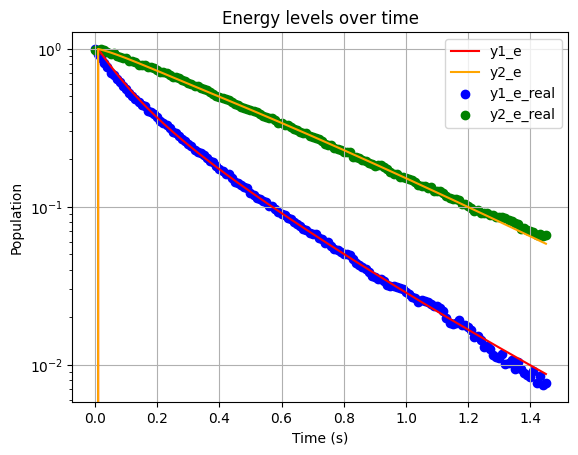

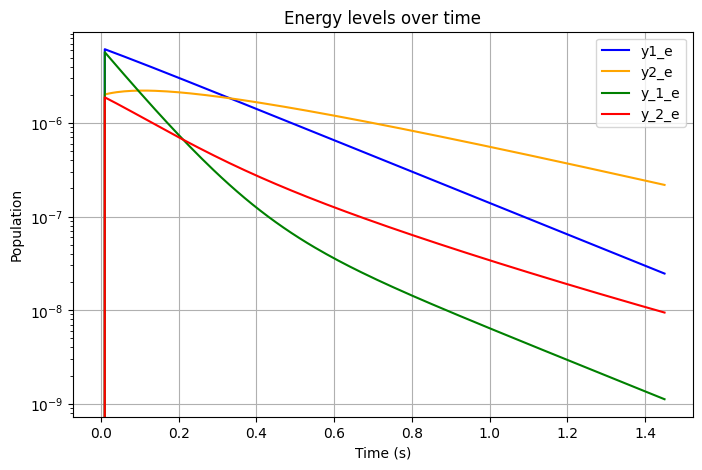

6.134915381388239e-06 2.4583997647579422e-08
2.0154976635908327e-06 2.1769295481025997e-07
5.704589900593707e-06 1.1165746478763443e-09
1.8774925628941237e-06 9.419353806063861e-09
q_fixed = 0.5008731883143941
m_fixed = 0.7640633869537243
kr1_fixed = 2.0126354587590916
k12_fixed = 6.425898087304737
k11_fixed = 0.9074228723620262
k22_fixed = 1.8600662377982116
kn1_fixed = 7.633758414416212
n1_fixed = 0.7133871533149713
global_best_score: 0.02497472686492843


In [74]:
sim_y1 = global_best_y1
sim_y2 = global_best_y2

plt.plot(t_data, sim_y1, label='y1_e', c= 'r')
plt.plot(t_data, sim_y2, label='y2_e', c= 'orange')

y1_e_measured = y1_e_measured
y2_e_measured = y2_e_measured

plt.scatter(t_data, y1_e_measured, label='y1_e_real', c= 'b')
plt.scatter(t_data, y2_e_measured, label='y2_e_real', c= 'g')

plt.title("Energy levels over time")
plt.xlabel("Time (s)")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.yscale('log')  # <-- y축을 로그 스케일로 설정
plt.savefig("100.png")
plt.show()


plt.figure(figsize=(8,5))


sim_y1 = global_best_y_all[:, 0]
sim_y2 = global_best_y_all[:, 1]
sim_y3 = global_best_y_all[:, 4]
sim_y4 = global_best_y_all[:, 5]

plt.plot(t_data, sim_y1, label='y1_e', c= 'b')
plt.plot(t_data, sim_y2, label='y2_e', c= 'orange')
plt.plot(t_data, sim_y3, label='y_1_e', c= 'g')
plt.plot(t_data, sim_y4, label='y_2_e', c= 'r')

"""plt.plot(times, sim_y5, label='y1_e', c= 'b')
plt.plot(times, sim_y6, label='y2_e', c= 'orange')
plt.plot(times, sim_y7, label='y_1_e', c= 'g')
plt.plot(times, sim_y8, label='y_2_e', c= 'r')"""

plt.title("Energy levels over time")
plt.xlabel("Time (s)")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.yscale('log')  # <-- y축을 로그 스케일로 설정
plt.savefig("100.png")
plt.show()


Ini_bound_y1 = global_best_y_all[1, 0]
Ini_bound_y2 = global_best_y_all[1, 1]
Ini_bound_y3 = global_best_y_all[1, 4]
Ini_bound_y4 = global_best_y_all[1, 5]

Term_bound_y1 = global_best_y_all[-1, 0]
Term_bound_y2 = global_best_y_all[-1, 1]
Term_bound_y3 = global_best_y_all[-1, 4]
Term_bound_y4 = global_best_y_all[-1, 5]

print(Ini_bound_y1,Term_bound_y1)
print(Ini_bound_y2,Term_bound_y2)
print(Ini_bound_y3,Term_bound_y3)
print(Ini_bound_y4,Term_bound_y4)


print('q_fixed =', q)
print('m_fixed =', m)
print('kr1_fixed =', kr1)
print('k12_fixed =', k12)
print('k11_fixed =', k11)
print('k22_fixed =', k22)
print('kn1_fixed =', kn1)
print('n1_fixed =', mix)
print("global_best_score:", best_score)